# Project 3 - Promoter Regions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

import utils
import project

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
df = project.compare_simulations(len(cerevisae), probas, ks=[2,4,6,8], num_seq=1000)

In [40]:
df.describe()

,2,4,6,8
count,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,1.580203,9.986698e-01,1.753189e-02,1.366343e-02
std,0.028151,9.517292e-15,6.942366e-18,1.041355e-16
min,1.532547,9.986698e-01,1.753189e-02,1.366343e-02
25%,1.570727,9.986698e-01,1.753189e-02,1.366343e-02
50%,1.589007,9.986698e-01,1.753189e-02,1.366343e-02
75%,1.589631,9.986698e-01,1.753189e-02,1.366343e-02
max,1.626472,9.986698e-01,1.753189e-02,1.366343e-02


In [4]:
files = ["sequences/regulatory_seqs_MET.fasta","sequences/regulatory_seq_PHO.fasta","sequences/regulatory_seqs_GAL.fasta"]

In [8]:
cerevisae,chromos_flattened, freqs , probas = utils.read_file("sequences/yeast_s_cerevisae_genomic_chr1-4.fna")

In [6]:
list(probas)

[0.29983548323371834,
 0.2011019721740499,
 0.19999697915577738,
 0.29906556543645435]

In [9]:
len(cerevisae)

4

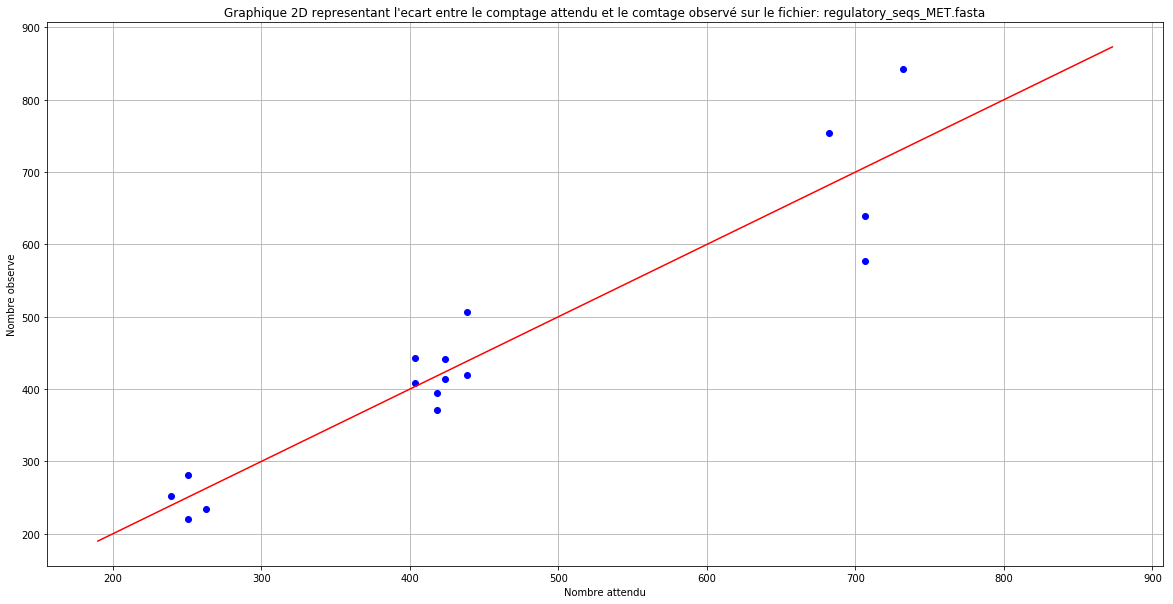

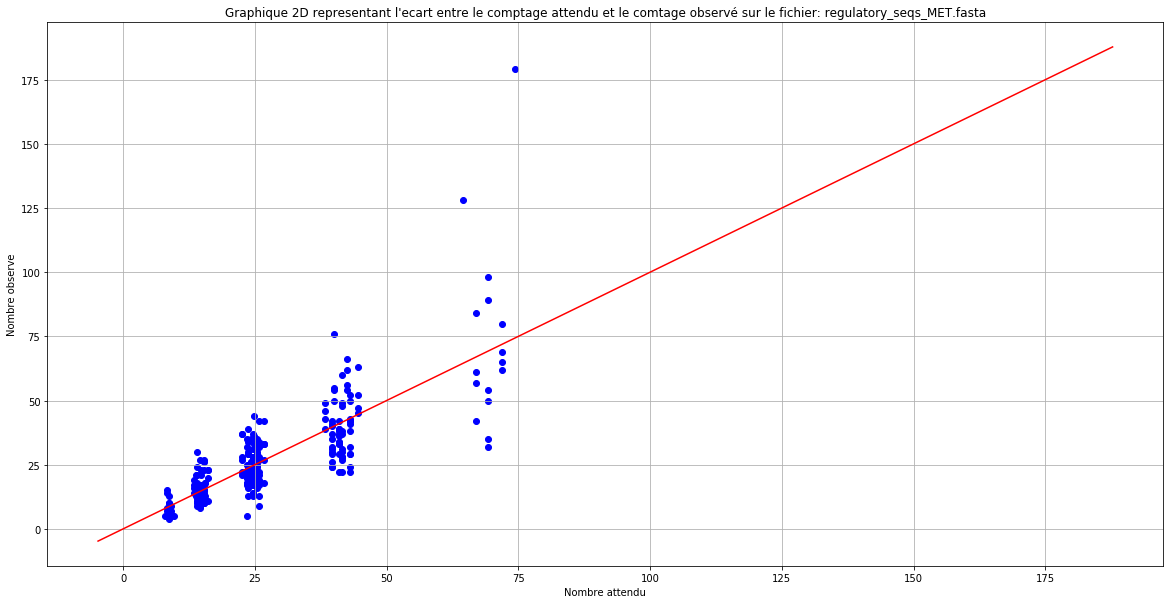

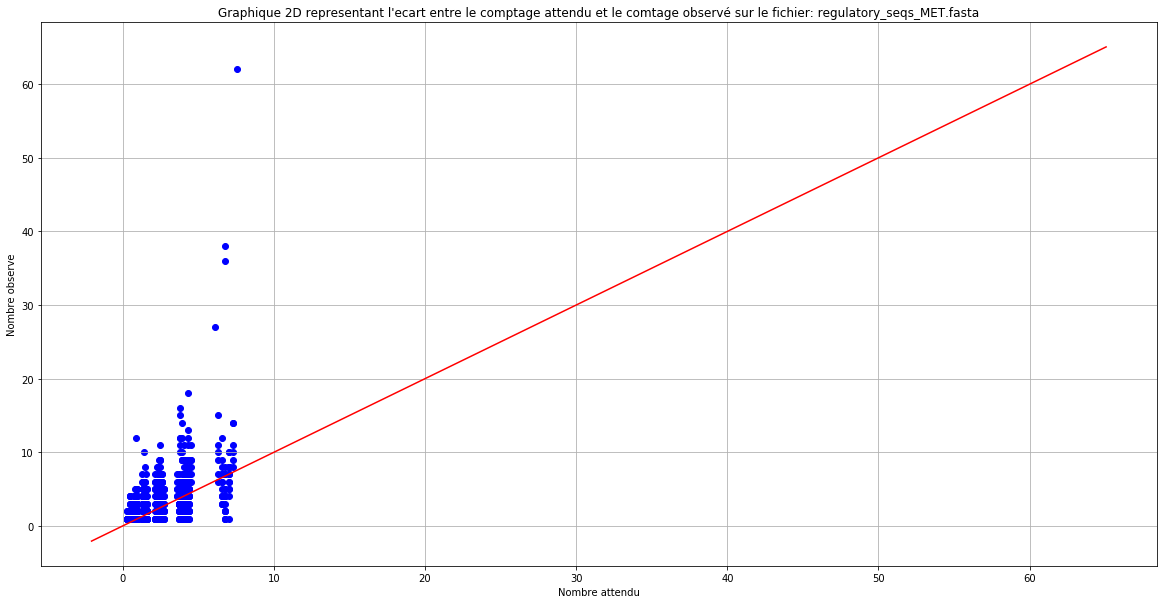

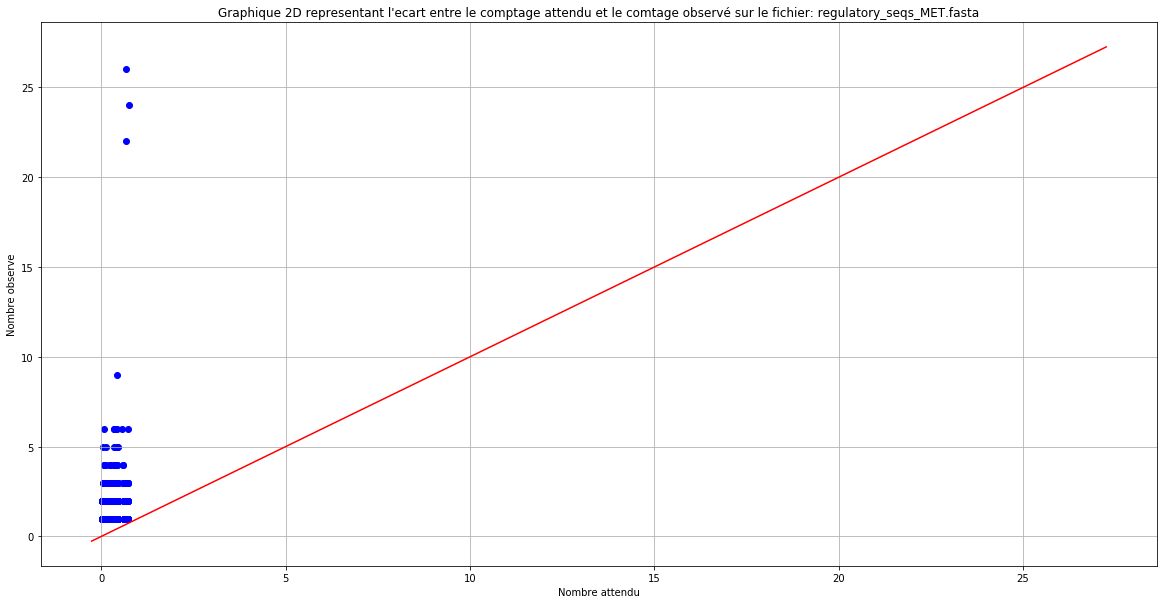

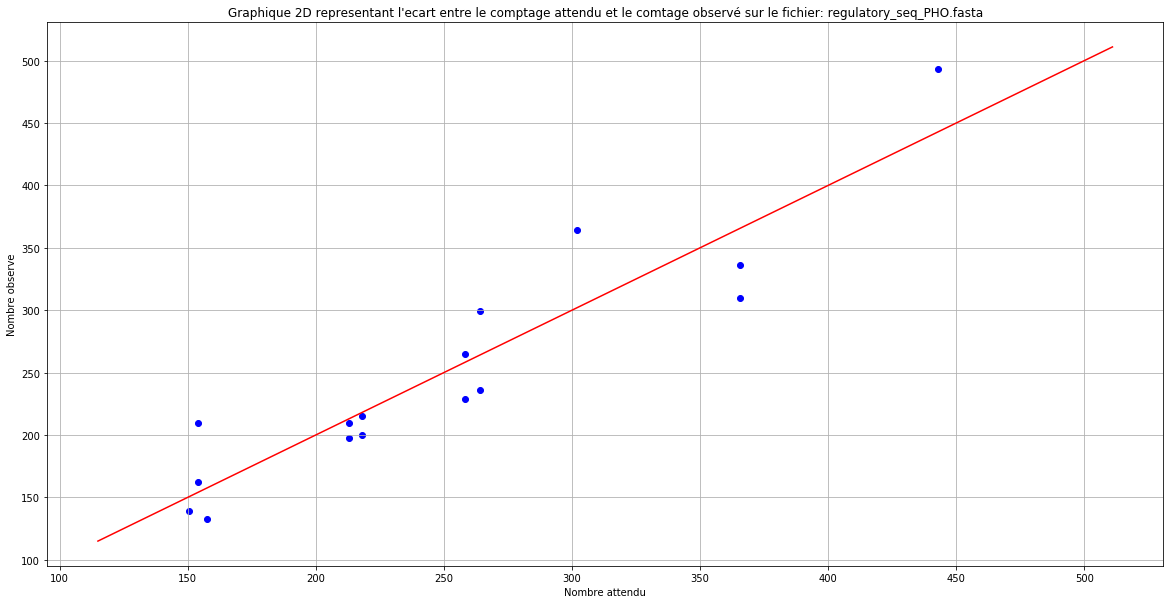

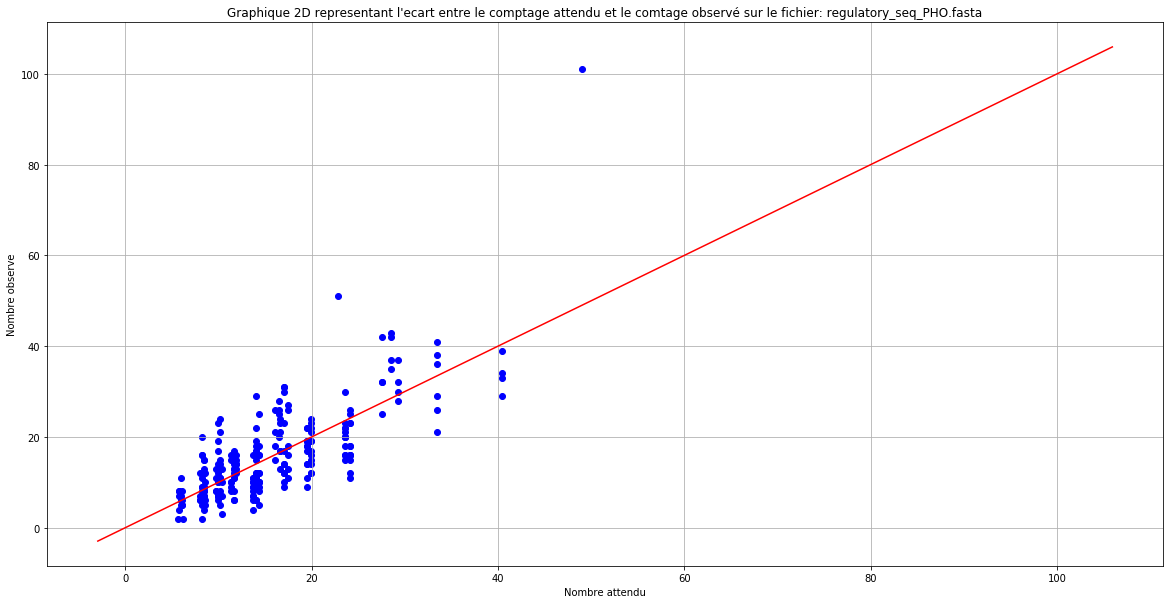

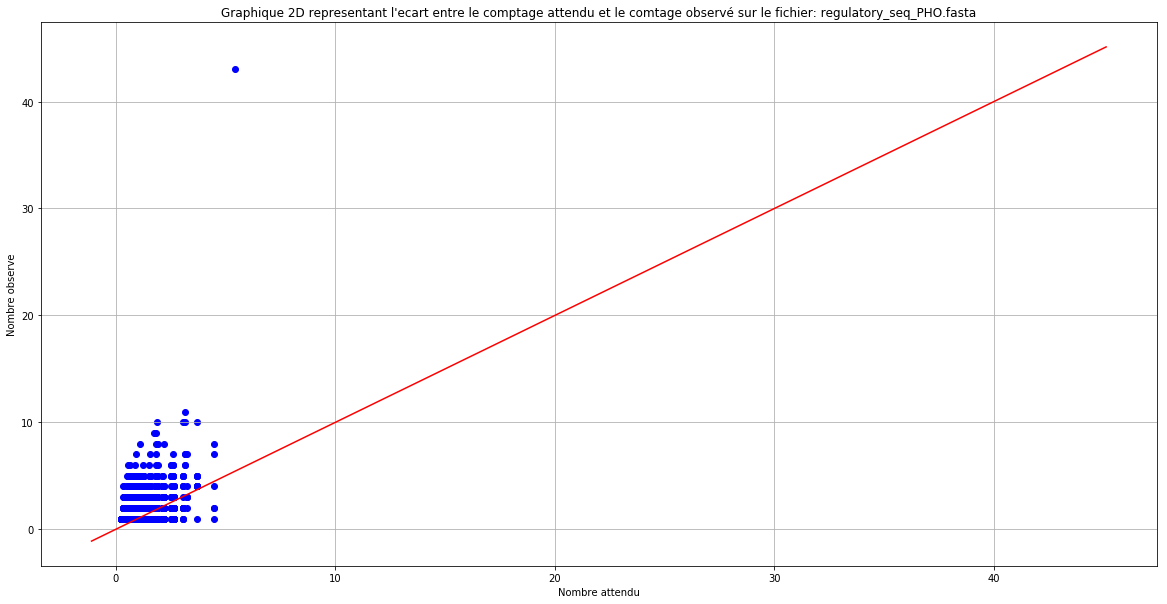

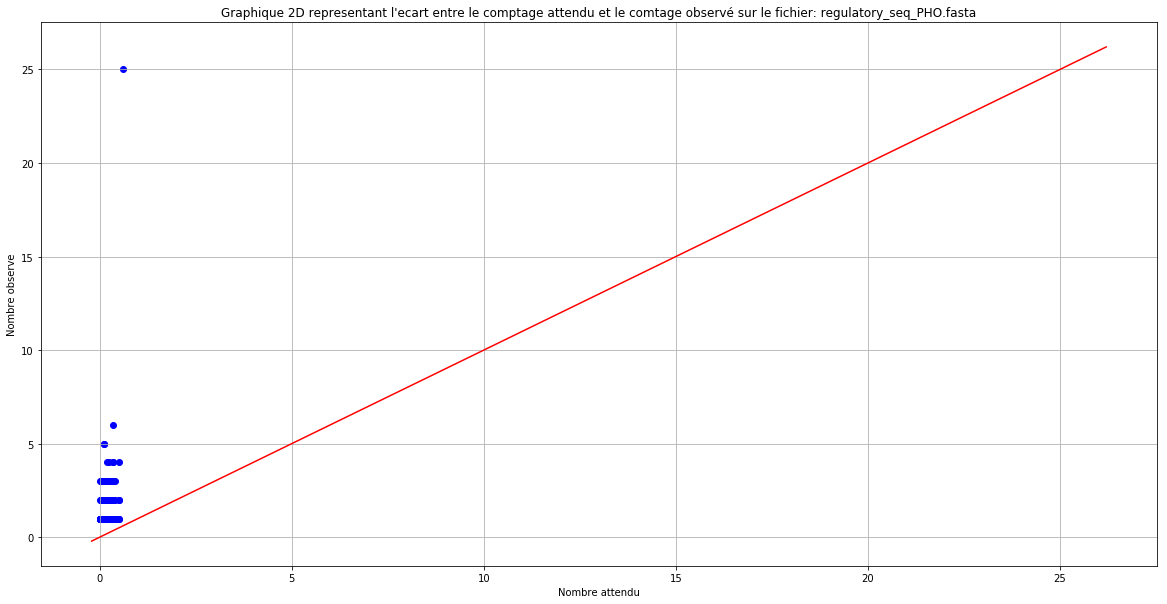

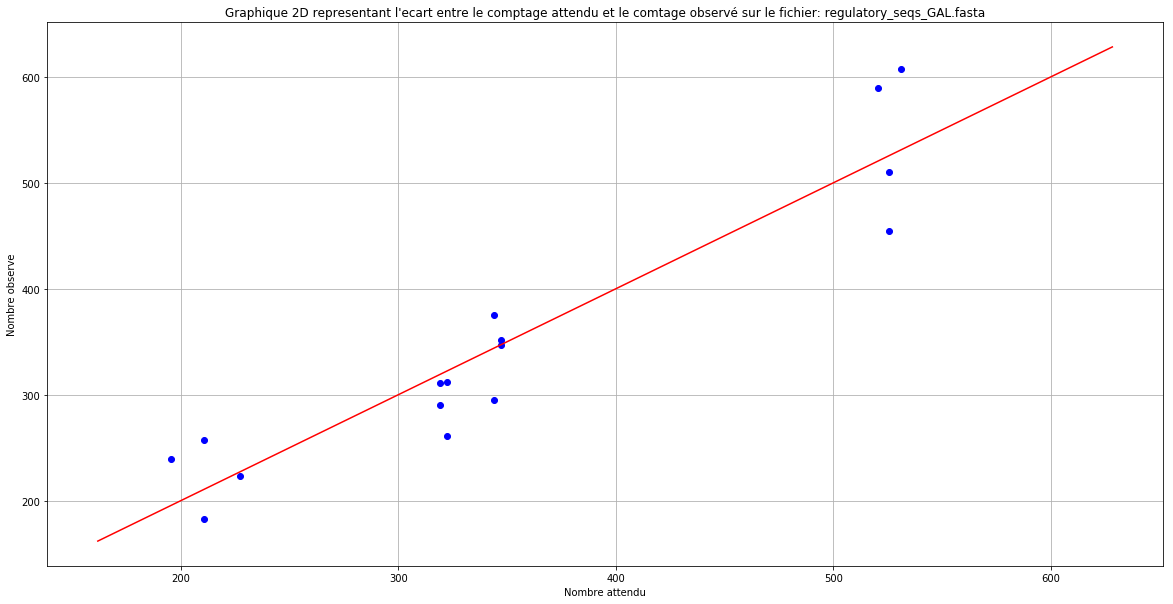

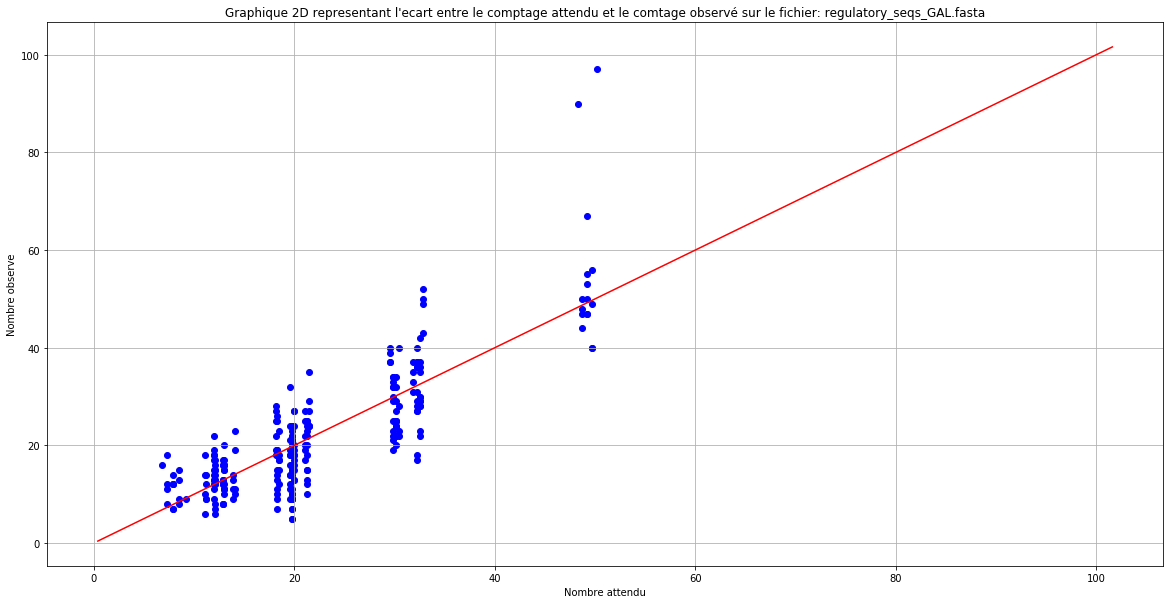

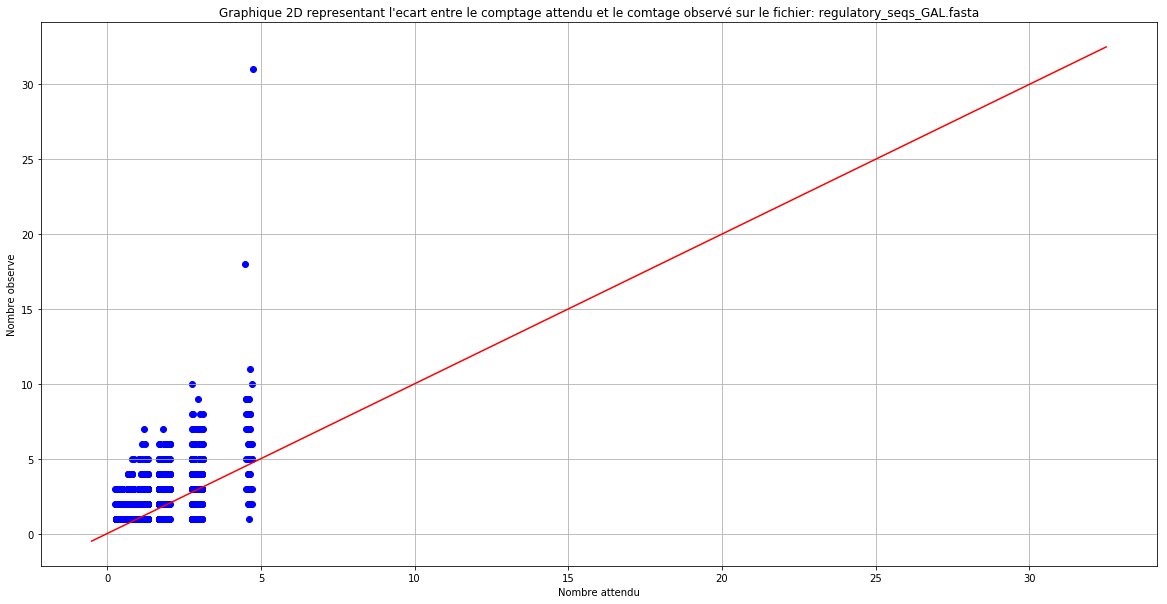

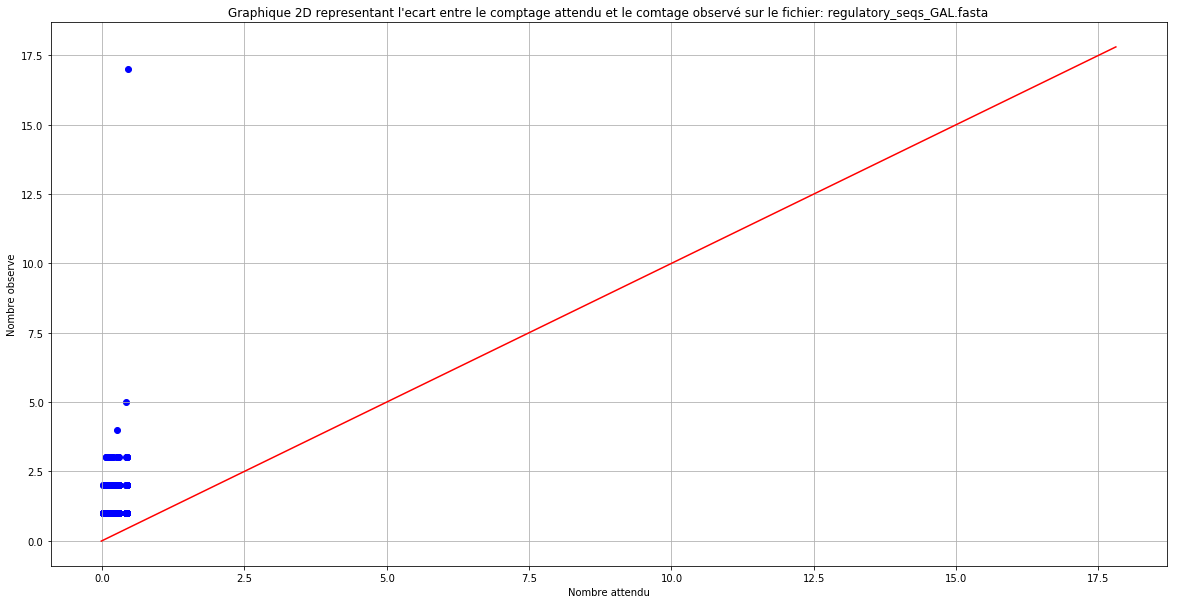

In [11]:
for i in range(len(files)):
    for j in [2,4,6,8]:
        utils.plot(files[i],j)

In [12]:
project.logproba(chromos_flattened, probas)

-3438164.462646954

In [25]:
project.logprobafast(freqs)

-3438164.4626394957

In [14]:
freqs

[754342, 505943, 503163, 752405]

In [24]:
project.logproba([1, 0, 3], (0.2, 0.3, 0.1, 0.4))

-3.7297014486341915

In [16]:
project.code('TAC', 3)

49

In [17]:
project.inv_code(49, 3)

'TAC'

In [18]:
project.inv_nucleotide

{0: 'A', 1: 'C', 2: 'G', 3: 'T'}

In [19]:
project.int_to_str('301')

'TAC'

In [ ]:
project.plot_histogram(chromos_flattened,probas,5)

In [21]:
project.k_grams_occurrences('ATCAT', 2)

{('A', 'T'): 2, ('C', 'A'): 1, ('T', 'C'): 1}

In [22]:
project.count_bigram('AAABCAB', 'A', 'A')

2

In [45]:
project.simule_sequence_markov(10, [0.2, 0.3, 0.1, 0.4], chromos_flattened)

[1, 0, 0, 1, 2, 3, 0, 2, 0, 2]

In [46]:
matrix = project.transition_matrix(chromos_flattened)

In [47]:
matrix, project.markov_proba([0,0,1, 3], matrix, probas)

(array([[0.3250462 , 0.18551797, 0.20059204, 0.28884379],
        [0.33570778, 0.2092548 , 0.1575632 , 0.29747422],
        [0.31321125, 0.20244971, 0.20774423, 0.27659481],
        [0.24149361, 0.2103415 , 0.2227537 , 0.32541118]]),
 0.00537852819841805)